In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import corner

import result_utils
import os; print(os.environ['LD_LIBRARY_PATH'])

/net/lem/data2/regt/MultiNest/lib:/software/rhel9-amd/lib64:


In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'

cmap_A = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_A])
env_colors_A = cmap_A([0,1/4,2/4,3/4,1])
env_colors_A[:,3] = 0.5; env_colors_A[0,3] = 0.0

cmap_B = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_B])
env_colors_B = cmap_B([0,1/4,2/4,3/4,1])
env_colors_B[:,3] = 0.5; env_colors_B[0,3] = 0.0

lw_d = 0.8
lw_m = 1.0

res_alpha = 0.85

path = '/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs'
A = result_utils.RetrievalResults(f'{path}/freechem_K_A_ret_6/test_')
B = result_utils.RetrievalResults(f'{path}/freechem_K_B_ret_6/test_')
A_eq = result_utils.RetrievalResults(f'{path}/eqchem_K_A_ret_3/test_')
B_eq = result_utils.RetrievalResults(f'{path}/eqchem_K_B_ret_4/test_')

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_A_ret_3/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_A_ret_3/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_B_ret_4/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_B_ret_4/test_.txt


In [3]:
def get_chemical_ratios(Res, mean_along_axis=None, P=0.4):
    
    # Load the chemistry module
    Res.load_components(['Chem'])

    m_set = Res.model_settings[0]
    VMRs = Res.Chem[m_set].VMRs_posterior

    posterior_shape = (Res.posterior.shape[0], len(Res.Chem[m_set].pressure))

    chem_ratios = {}
    chem_ratios['C/O'] = (
        (VMRs.get('12CO',0.)+VMRs.get('CH4',0.)+VMRs.get('13CO',0.)) / 
        (VMRs.get('12CO',0.)+VMRs.get('13CO',0.)+VMRs.get('H2O',0.))
    )

    # Isotope ratios
    chem_ratios['12CO/13CO'] = VMRs.get('12CO',0.) / VMRs.get('13CO',np.inf)
    chem_ratios['C16O/C18O'] = VMRs.get('12CO',0.) / VMRs.get('C18O',np.inf)
    chem_ratios['C16O/C17O'] = VMRs.get('12CO',0.) / VMRs.get('C17O',np.inf)
    
    chem_ratios['H2O/HDO'] = VMRs.get('H2O',0.) / VMRs.get('HDO',np.inf)
    chem_ratios['H2(16)O/H2(18)O'] = VMRs.get('H2O',0.) / VMRs.get('H2(18)O',np.inf)
    chem_ratios['H2(16)O/H2(17)O'] = VMRs.get('H2O',0.) / VMRs.get('H2(17)O',np.inf)

    chem_ratios['12CH4/13CH4'] = VMRs.get('CH4',0.) / VMRs.get('13CH4',np.inf)
    chem_ratios['14NH3/15NH3'] = VMRs.get('NH3',0.) / VMRs.get('15NH3',np.inf)
    
    # Absolute abundances
    abs_abund = {}
    solar = {
        'C':10**8.46, 'N':10**7.83, 'O':10**8.69, 'F':10**4.40, 'S':10**7.12, 'H':10**12.0, 
        'Na': 10**6.22, 'K': 10**5.07, 'Fe': 10**7.46, 
        }

    VMR_H = (
        VMRs.get('H2',0.)*2 + VMRs.get('H2O',0.)*2 + VMRs.get('CH4',0.)*4 + \
        VMRs.get('NH3',0.)*3 + VMRs.get('H2S',0.)*2 + VMRs.get('HF',0.)*1 + \
        VMRs.get('FeH',0.)*1 
    )
    VMR_C = VMRs.get('12CO',0.) + VMRs.get('CH4',0.) + VMRs.get('13CO',0.)
    VMR_N = VMRs.get('NH3',0.)
    VMR_O = VMRs.get('H2O',0.) + VMRs.get('12CO',0.) + VMRs.get('13CO',0.)
    VMR_F = VMRs.get('HF',0.)
    VMR_S = VMRs.get('H2S',0.)
    
    VMR_Na = VMRs.get('Na',0.)
    VMR_K = VMRs.get('K',0.)
    VMR_Fe = VMRs.get('Fe',0.) + VMRs.get('FeH',0.)

    abs_abund['C/H'] = np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H'])
    abs_abund['N/H'] = np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H'])
    abs_abund['O/H'] = np.log10(VMR_O/VMR_H) - np.log10(solar['O']/solar['H'])
    abs_abund['F/H'] = np.log10(VMR_F/VMR_H) - np.log10(solar['F']/solar['H'])
    abs_abund['S/H'] = np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H'])
    abs_abund['Na/H'] = np.log10(VMR_Na/VMR_H) - np.log10(solar['Na']/solar['H'])
    abs_abund['K/H'] = np.log10(VMR_K/VMR_H) - np.log10(solar['K']/solar['H'])
    abs_abund['Fe/H'] = np.log10(VMR_Fe/VMR_H) - np.log10(solar['Fe']/solar['H'])

    abs_abund['(C+O)/H'] = (
        np.log10((VMR_C+VMR_O)/VMR_H) - np.log10((solar['C']+solar['O'])/solar['H'])
    )
    abs_abund['M/H'] = (
        np.log10((VMR_C+VMR_N+VMR_O+VMR_F+VMR_S+VMR_Na+VMR_K+VMR_Fe)/VMR_H) - \
        np.log10((
            solar['C']+solar['N']+solar['O']+solar['F']+solar['S']+solar['Na']+solar['K']+solar['Fe']
            )/solar['H'])
    )
            
    if mean_along_axis is not None:

        idx_P = np.argmin(np.abs(Res.Chem[m_set].pressure-P))
        keys = list(chem_ratios.keys())

        for key in keys:
            if isinstance(chem_ratios[key], float):
                chem_ratios[key] = np.ones(posterior_shape) * chem_ratios[key]

            #chem_ratios[key] = np.mean(chem_ratios[key], axis=mean_along_axis)
            chem_ratios[key] = chem_ratios[key][:,idx_P]

            # For chemical equilibrium retrievals
            idx = Res.ParamTable.get(key, key='idx_free')
            if idx is not None:
                print(idx, key)
                chem_ratios[f'{key}_mean'] = chem_ratios[key].copy()
                chem_ratios[key] = Res.posterior[:,idx]
            
            idx = Res.ParamTable.get(f'log_{key.split("/")[-1]}_ratio', key='idx_free')
            if idx is not None:
                print(idx, 'log_'+key)
                chem_ratios[f'{key}_mean'] = chem_ratios[key].copy()
                chem_ratios[key] = 10**Res.posterior[:,idx]

        for key in abs_abund.keys():
            if isinstance(abs_abund[key], float):
                abs_abund[key] = np.ones(posterior_shape) * abs_abund[key]

            #abs_abund[key] = np.mean(abs_abund[key], axis=mean_along_axis)
            abs_abund[key] = abs_abund[key][:,idx_P]

        idx_P = np.argsort(np.abs(Res.Chem[m_set].pressure-P))[:4]
        from scipy.interpolate import interp1d
        for key, VMR in VMRs.items():
            f = interp1d(np.log10(Res.Chem[m_set].pressure[idx_P]), np.log10(VMR[:,idx_P]))
            # Interpolate the VMRs to the desired pressure
            abs_abund[key] = 10**f(np.log10(P))
            # abs_abund[key] = np.mean(VMR[:,idx_P])

    return chem_ratios, abs_abund

chem_ratios_A, abs_abund_A = get_chemical_ratios(A, mean_along_axis=-1)
chem_ratios_B, abs_abund_B = get_chemical_ratios(B, mean_along_axis=-1)

chem_ratios_A_eq, abs_abund_A_eq = get_chemical_ratios(A_eq, mean_along_axis=-1)
chem_ratios_B_eq, abs_abund_B_eq = get_chemical_ratios(B_eq, mean_along_axis=-1)

/var/tmp/regt/ipykernel_2279777/2489672473.py:56: RuntimeWarning: divide by zero encountered in log10
  abs_abund['Na/H'] = np.log10(VMR_Na/VMR_H) - np.log10(solar['Na']/solar['H'])
/var/tmp/regt/ipykernel_2279777/2489672473.py:57: RuntimeWarning: divide by zero encountered in log10
  abs_abund['K/H'] = np.log10(VMR_K/VMR_H) - np.log10(solar['K']/solar['H'])
/var/tmp/regt/ipykernel_2279777/2489672473.py:58: RuntimeWarning: divide by zero encountered in log10
  abs_abund['Fe/H'] = np.log10(VMR_Fe/VMR_H) - np.log10(solar['Fe']/solar['H'])


8 C/O
11 log_12CO/13CO
12 log_C16O/C18O
13 log_C16O/C17O
14 log_H2(16)O/H2(18)O
15 log_H2(16)O/H2(17)O
8 C/O
11 log_12CO/13CO
12 log_C16O/C18O
13 log_C16O/C17O
14 log_H2(16)O/H2(18)O
15 log_H2(16)O/H2(17)O


In [4]:
A_J = result_utils.RetrievalResults(f'{path}/J_A_ret_22_1column_n1000/test_')
B_J = result_utils.RetrievalResults(f'{path}/J_B_ret_62_1column_n1000/test_')

A_J.model_settings = ['J1226_1']; B_J.model_settings = ['J1226_1']

A_J.load_components(['Chem'])
B_J.load_components(['Chem'])

chem_ratios_A_J, abs_abund_A_J = get_chemical_ratios(A_J, mean_along_axis=-1, P=10**(np.log10(7.)-0.2))
print(np.median(abs_abund_A_J['FeH']))
chem_ratios_B_J, abs_abund_B_J = get_chemical_ratios(B_J, mean_along_axis=-1, P=10**(np.log10(7.)+0.2))

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_A_ret_22_1column_n1000/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_A_ret_22_1column_n1000/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_B_ret_62_1column_n1000/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_B_ret_62_1column_n1000/test_.txt
1.5435911061605508e-09


/var/tmp/regt/ipykernel_2279777/2489672473.py:51: RuntimeWarning: divide by zero encountered in log10
  abs_abund['C/H'] = np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H'])
/var/tmp/regt/ipykernel_2279777/2489672473.py:52: RuntimeWarning: divide by zero encountered in log10
  abs_abund['N/H'] = np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H'])
/var/tmp/regt/ipykernel_2279777/2489672473.py:55: RuntimeWarning: divide by zero encountered in log10
  abs_abund['S/H'] = np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H'])


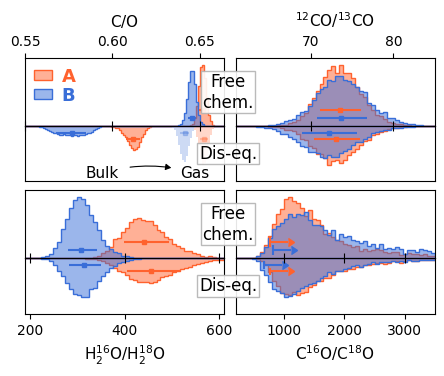

In [5]:
def plot_errorbar(ax, posterior, y, q, transform=None, ms=3.5, fmt='s', **kwargs):

    x = np.median(posterior)
    xerr = np.quantile(posterior, q=q) - x
    xerr = np.abs(xerr)[:,None]

    if transform is None:
        transform = ax.get_xaxis_transform()

    if xerr.shape[0] == 1:
        ax.errorbar(
            x-xerr, y, yerr=0.07, transform=transform, fmt='', lw=1.5, ms=ms, capsize=0, xlolims=True, **kwargs,
            )
    else:
        ax.errorbar(
            x, y, xerr=xerr, transform=transform, fmt=fmt, lw=1.5, ms=ms, capsize=0, **kwargs,
            )

hist_kwargs_A = dict(
    #bins=25, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
    histtype='stepfilled', fc=env_colors_A[-1], ec=color_A, lw=lw_m, bottom=0, density=True
)

hist_kwargs_B = hist_kwargs_A.copy()
hist_kwargs_B['fc'] = env_colors_B[-1]
hist_kwargs_B['ec'] = color_B

hist_kwargs_A_eq = hist_kwargs_A.copy()
# hist_kwargs_A_eq['fc'] = env_colors_A[2]
# hist_kwargs_A_eq['hatch'] = '\\\\'

hist_kwargs_B_eq = hist_kwargs_B.copy()
# hist_kwargs_B_eq['fc'] = env_colors_B[2]
# hist_kwargs_B_eq['hatch'] = '//'

hist_kwargs_gas = hist_kwargs_A.copy()
hist_kwargs_gas.pop('fc', None)
hist_kwargs_gas['ec'] = 'none'
# hist_kwargs_gas['lw'] = 0.8

hist_info = {
    'C/O':             (100, [0.550, 0.664]), 
    '12CO/13CO':       (50, [61,85]), 
    'H2(16)O/H2(18)O': (50, [190,610]), 
    'C16O/C18O':       (50, [200,3500]), 
}

fig = plt.figure(figsize=(4.5,3.7))
gs = fig.add_gridspec(
    # nrows=5, ncols=2, hspace=0., wspace=0.08, height_ratios=[1,1,0.2,1,1],
    nrows=5, ncols=2, hspace=0., wspace=0.06, height_ratios=[1.1,0.9,0.15,1.1,0.9],
)
ax_1 = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
ax_2 = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]
ax_2 += [fig.add_subplot(gs[4,0]), fig.add_subplot(gs[4,1])]
ax_1 += [fig.add_subplot(gs[3,0]), fig.add_subplot(gs[3,1])]
ax_1 = np.array(ax_1)
ax_2 = np.array(ax_2)

for i, key in enumerate(hist_info.keys()):
    bins, hist_range = hist_info[key]

    handle_A = ax_1[i].hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
    handle_B = ax_1[i].hist(chem_ratios_B[key], label='B', bins=bins, range=hist_range, **hist_kwargs_B)
    ax_2[i].hist(chem_ratios_A_eq[key], bins=bins, range=hist_range, **hist_kwargs_A_eq)
    ax_2[i].hist(chem_ratios_B_eq[key], bins=bins, range=hist_range, **hist_kwargs_B_eq)

    if key == 'C/O':
        ax_2[i].hist(chem_ratios_A_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_A[2], **hist_kwargs_gas)
        ax_2[i].hist(chem_ratios_B_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_B[2], **hist_kwargs_gas)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[f'{key}_mean'], y=0.76, q=result_utils.q[[2,4]], color=color_A, alpha=0.3)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[f'{key}_mean'], y=0.88, q=result_utils.q[[2,4]], color=color_B, alpha=0.3)

    if key != 'C16O/C18O':
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[2,4]], color=color_A)
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[2,4]], color=color_B)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[2,4]], color=color_A)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[2,4]], color=color_B)
    else:
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[1]], color=color_A, xerr=300)
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[1]], color=color_B, xerr=300)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[1]], color=color_A, xerr=300)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[1]], color=color_B, xerr=300)


    ylim = ax_1[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.05]
    ax_1[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')

    ylim = ax_2[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.35]
    ax_2[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')
    ax_2[i].yaxis.set_inverted(True)

ax_1[0].tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
ax_1[1].tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
ax_2[0].tick_params(axis='x', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=7)
ax_2[1].tick_params(axis='x', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=7)

ax_1[2].tick_params(axis='x', labelbottom=False, direction='inout', length=7)
ax_1[3].tick_params(axis='x', labelbottom=False, direction='inout', length=7)

ax_1[0].set_xlabel(r'$\mathrm{C/O}$', fontsize=11, labelpad=6.0)
ax_1[1].set_xlabel(r'$\mathrm{^{12}CO/^{13}CO}$', fontsize=11, labelpad=6.0)
ax_2[2].set_xlabel(r'$\mathrm{H_2^{16}O/H_2^{18}O}$', fontsize=11)
ax_2[3].set_xlabel(r'$\mathrm{C^{16}O/C^{18}O}$', fontsize=11)

ax_1[0].xaxis.set_label_position('top')
ax_1[1].xaxis.set_label_position('top')

ann_kwargs = dict(
    xycoords='axes fraction', ha='center', va='center', fontsize=12, 
    bbox={'boxstyle':'square,pad=0.1', 'ec':'0.7', 'fc':'w', 'alpha':0.9}, 
)
for i in [1,3]:
    ax_1[i].annotate('Free\nchem.', xy=(-0.04,0.5), **ann_kwargs)
    ax_2[i].annotate('Dis-eq.', xy=(-0.04,0.5), **ann_kwargs)

ann_kwargs = dict(xycoords=ax_2[0].get_xaxis_transform(), ha='center', va='center', fontsize=11)

xy = (np.mean([np.median(chem_ratios_A_eq['C/O_mean']),np.median(chem_ratios_B_eq['C/O_mean'])]),0.15)
ax_2[0].annotate('Gas', xy=xy, **ann_kwargs)
xytext = (np.mean([np.median(chem_ratios_A_eq['C/O']),np.median(chem_ratios_B_eq['C/O'])]),0.15)
ax_2[0].annotate(
    'Bulk', xy=xy, xytext=xytext, **ann_kwargs, arrowprops=dict(
        arrowstyle='-|>,head_width=0.17,head_length=0.3', shrinkB=17, shrinkA=6, 
        connectionstyle='arc3,rad=-0.15', lw=0.8, color='k'
        )
    )

ax_1[0].legend(
    loc='upper left', bbox_to_anchor=(0.,1.), labelspacing=0.05, handlelength=1.0, handleheight=0.5, 
    handletextpad=0.5, borderpad=0., labelcolor=[color_A, color_B], prop={'weight':'bold', 'size':13}, frameon=False, 
)

plt.subplots_adjust(left=0.05, bottom=0.16, top=0.85, right=0.96)
plt.savefig(f'./plots/K_band_chem_ratios.pdf')
plt.show()

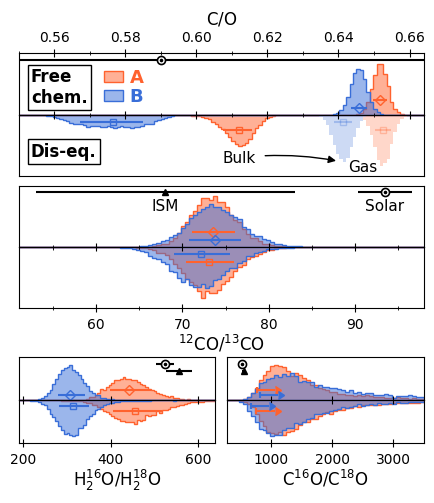

In [6]:
hist_info = {
    'C/O':             (120, [0.550, 0.664]), 
    '12CO/13CO':       (100, [51,98]), 
    'H2(16)O/H2(18)O': (70, [190,640]), 
    'C16O/C18O':       (50, [280,3500]), 
}

fig = plt.figure(figsize=(4.5,5.))
gs = fig.add_gridspec(
    # nrows=5, ncols=2, hspace=0., wspace=0.08, height_ratios=[1,1,0.2,1,1],
    nrows=8, ncols=2, hspace=0., wspace=0.06, height_ratios=[1.,1.,0.15,1.,1.,0.8,0.7,0.7],
)

ax_1 = np.array([
    fig.add_subplot(gs[0,:]),fig.add_subplot(gs[3,:]),fig.add_subplot(gs[6,0]),fig.add_subplot(gs[6,1])
    ])
ax_2 = np.array([
    fig.add_subplot(gs[1,:]),fig.add_subplot(gs[4,:]),fig.add_subplot(gs[7,0]),fig.add_subplot(gs[7,1])
    ]) 

ax_1[0].set_xticks(np.arange(0.55,0.67,0.01), minor=True)
ax_2[0].set_xticks(np.arange(0.55,0.67,0.01), minor=True)
ax_1[1].set_xticks(np.arange(50,100,5), minor=True)
ax_2[1].set_xticks(np.arange(50,100,5), minor=True)

for i, key in enumerate(hist_info.keys()):
    bins, hist_range = hist_info[key]

    handle_A = ax_1[i].hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
    handle_B = ax_1[i].hist(chem_ratios_B[key], label='B', bins=bins, range=hist_range, **hist_kwargs_B)
    handle_A = ax_2[i].hist(chem_ratios_A_eq[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A_eq)
    handle_B = ax_2[i].hist(chem_ratios_B_eq[key], label='B', bins=bins, range=hist_range, **hist_kwargs_B_eq)

    if key == 'C/O':
        ax_2[i].hist(chem_ratios_A_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_A[2], **hist_kwargs_gas)
        ax_2[i].hist(chem_ratios_B_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_B[2], **hist_kwargs_gas)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[f'{key}_mean'], y=0.76, q=result_utils.q[[2,4]], color=color_A, alpha=0.3, ms=5, mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_B_eq[f'{key}_mean'], y=0.88, q=result_utils.q[[2,4]], color=color_B, alpha=0.3, ms=5, mfc='none')

    if key != 'C16O/C18O':
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[2,4]], color=color_A, ms=5, fmt='D', mfc='none')
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[2,4]], color=color_B, ms=5, fmt='D', mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[2,4]], color=color_A, ms=5, mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[2,4]], color=color_B, ms=5, mfc='none')
    else:
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[1]], color=color_A, xerr=300, ms=5, fmt='D', mfc='none')
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[1]], color=color_B, xerr=300, ms=5, fmt='D', mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[1]], color=color_A, xerr=300, ms=5, mfc='none')
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[1]], color=color_B, xerr=300, ms=5, mfc='none')

    ylim = ax_1[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.15]
    ax_1[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')

    ylim = ax_2[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.15]
    ax_2[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')
    ax_2[i].yaxis.set_inverted(True)

ax_1[0].tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, direction='inout', length=6)
ax_1[0].tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, labelbottom=False, direction='inout', length=3)
ax_2[0].tick_params(axis='x', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=6)
ax_2[0].tick_params(axis='x', which='minor', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=3)

ax_1[1].tick_params(axis='x', bottom=False, labelbottom=False)
ax_2[1].tick_params(axis='x', top=True, labeltop=False, bottom=True, labelbottom=True, direction='inout', length=6)
ax_2[1].tick_params(axis='x', which='minor', top=True, labeltop=False, bottom=True, labelbottom=True, direction='inout', length=3)

ax_1[2].tick_params(axis='x', bottom=False, labelbottom=False)
ax_1[3].tick_params(axis='x', bottom=False, labelbottom=False)
ax_2[2].tick_params(axis='x', top=True, labeltop=False, bottom=True, labelbottom=True, direction='inout', length=6)
ax_2[3].tick_params(axis='x', top=True, labeltop=False, bottom=True, labelbottom=True, direction='inout', length=6)

ax_1[0].set_xlabel(r'$\mathrm{C/O}$', fontsize=12, labelpad=5)
ax_2[1].set_xlabel(r'$\mathrm{^{12}CO/^{13}CO}$', fontsize=12, labelpad=1.0)
ax_2[2].set_xlabel(r'$\mathrm{H_2^{16}O/H_2^{18}O}$', fontsize=12, labelpad=1.0)
ax_2[3].set_xlabel(r'$\mathrm{C^{16}O/C^{18}O}$', fontsize=12, labelpad=1.0)

ax_1[0].xaxis.set_label_position('top')

ann_kwargs = dict(xycoords=ax_2[0].get_xaxis_transform(), ha='center', va='center', fontsize=11)
arrowprops = dict(
    arrowstyle='-|>,head_width=0.2,head_length=0.4', shrinkB=20, shrinkA=5, connectionstyle='arc3,rad=-0.1', lw=1, color='k'
)
xy = (np.mean([np.median(chem_ratios_A_eq['C/O_mean']),np.median(chem_ratios_B_eq['C/O_mean'])]),0.15)
xytext = (np.median(chem_ratios_A_eq['C/O']),0.3)
ax_2[0].annotate('Gas', xy=xy, **ann_kwargs)
ax_2[0].annotate('Bulk', xy=xy, xytext=xytext, **ann_kwargs, arrowprops=arrowprops)

ax_1[0].legend(
    loc='lower center', bbox_to_anchor=(0.26,0.), labelspacing=0.05, handlelength=1.0, handleheight=0.5, 
    handletextpad=0.4, borderpad=0., labelcolor=[color_A, color_B], prop={'weight':'bold', 'size':13}, frameon=False, 
)

def add_odot(ax, x, y, color='k', ms=5, mec='w', transform=None):
    if transform is None:
        transform = ax.get_xaxis_transform()
    ax.plot([x], [y], 'o', transform=transform, ms=ms, c=color)
    ax.plot([x], [y], 'o', transform=transform, ms=ms*3/5, mfc='none', mec=mec)

kwargs = dict(lw=1.5, ms=5, capsize=0, c='k')
ann_kwargs = dict(ha='center', va='top', fontsize=11)
y = 0.89; ydiff = 0.1
ax_1[0].errorbar(0.59, y, xerr=0.08, transform=ax_1[0].get_xaxis_transform(), fmt='', **kwargs)

ax_1[1].errorbar(68, y, xerr=15, transform=ax_1[1].get_xaxis_transform(), fmt='^', **kwargs)
ax_1[1].errorbar(93.5, y, xerr=3.1, transform=ax_1[1].get_xaxis_transform(), fmt='', **kwargs)
ax_1[1].annotate('Solar', xy=(93.5,y-ydiff), xycoords=ax_1[1].get_xaxis_transform(), **ann_kwargs)
ax_1[1].annotate('ISM', xy=(68,y-ydiff), xycoords=ax_1[1].get_xaxis_transform(), **ann_kwargs)
add_odot(ax_1[0], 0.59, y, color='k', ms=6, mec='w')
add_odot(ax_1[1], 93.5, y, color='k', ms=6, mec='w')

y -= 0.05
ax_1[2].errorbar(525, y, xerr=21, transform=ax_1[2].get_xaxis_transform(), fmt='', **kwargs) # (Solar) Lyons et al. (2018)
# ax_1[2].errorbar(395, y, xerr=56, transform=ax_1[2].get_xaxis_transform(), fmt='^', **kwargs) # (ISM) Polehampton et al. (2005)
ax_1[2].errorbar(557, y-0.15, xerr=30, transform=ax_1[2].get_xaxis_transform(), fmt='^', **kwargs) # (ISM) Polehampton et al. (2005)

ax_1[3].errorbar(525, y, xerr=21, transform=ax_1[3].get_xaxis_transform(), fmt='', **kwargs) # (Solar) Lyons et al. (2018)
# ax_1[3].errorbar(395, y, xerr=56, transform=ax_1[3].get_xaxis_transform(), fmt='^', **kwargs) # (ISM) Polehampton et al. (2005)
ax_1[3].errorbar(557, y-0.15, xerr=30, transform=ax_1[3].get_xaxis_transform(), fmt='^', **kwargs) # (ISM) Polehampton et al. (2005)

add_odot(ax_1[2], 525, y, color='k', ms=6, mec='w')
add_odot(ax_1[3], 525, y, color='k', ms=6, mec='w')

ann_kwargs = dict(
    xycoords='axes fraction', fontsize=12, ha='left', va='center', fontweight='bold', 
    bbox={'boxstyle':'square,pad=0.2', 'ec':'k', 'fc':'w', 'alpha':1}
)
ax_1[0].annotate('Free\nchem.', xy=(0.03, 0.45), **ann_kwargs)
ax_2[0].annotate('Dis-eq.', xy=(0.03, 0.4), **ann_kwargs)

plt.subplots_adjust(left=0.05, bottom=0.11, top=0.89, right=0.95)
plt.savefig(f'./plots/K_band_chem_ratios.pdf')
plt.show()

In [19]:
result_utils.latex_format(
    (chem_ratios_A_eq['C/O_mean']-chem_ratios_A_eq['C/O'])/chem_ratios_A_eq['C/O_mean'] * 100, 
    (chem_ratios_B_eq['C/O_mean']-chem_ratios_B_eq['C/O'])/chem_ratios_B_eq['C/O_mean'] * 100
)

$6.19^{+0.56}_{-0.45}$ & $10.10^{+1.41}_{-1.30}$ \\


In [7]:
# result_utils.latex_format(chem_ratios_A_eq['C/O'], chem_ratios_B_eq['C/O'], decimals=3)

result_utils.latex_format(chem_ratios_A['C/O'], chem_ratios_B['C/O'], decimals=3)
result_utils.latex_format(chem_ratios_A['12CO/13CO'], chem_ratios_B['12CO/13CO'], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[[4,2]], decimals=0)
result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[1], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[0], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[1], decimals=0)
result_utils.latex_format(chem_ratios_A['H2(16)O/H2(18)O'], chem_ratios_B['H2(16)O/H2(18)O'], decimals=0)

$0.652^{+0.002}_{-0.002}$ & $0.646^{+0.002}_{-0.002}$ \\
$74^{+3}_{-2}$ & $74^{+3}_{-3}$ \\
$>764.0$ & $>815.0$ \\
$441^{+52}_{-43}$ & $308^{+33}_{-28}$ \\


In [ ]:
lolim = []
uplim = ['log_H2(17)O', 'log_C18O', 'log_C17O', 'log_CO2', 'log_HCN']
# result_utils.q[1]
indices = [
    ('log_H2O', 3), 
    'log_H2(18)O', 
    'log_H2(17)O', 
    ('log_12CO', 3), 
    'log_13CO', 
    'log_C18O', 
    'log_C17O', 
    'log_CH4', 
    'log_NH3', 
    'log_H2S', 
    'log_HF', 
    'log_CO2', 
    'log_HCN', 
    '-----', 
    'log_g', 
    'vsini', 
    'rv', 
    '-----', 
    'dlnT_dlnP_0', 
    ('dlnT_dlnP_1', 3),
    ('dlnT_dlnP_2', 3), 
    'dlnT_dlnP_3', 
    'dlnT_dlnP_4', 
    'log_P_phot', 
    ('T_phot', 0), 
    'd_log_P_phot-1', 
    'd_log_P_phot+1', 
    '-----', 
    'log_opa_base_gray', 
    'log_P_base_gray', 
    'f_sed_gray', 
    '-----', 
    ('log_a', 3), 
    ('log_l', 3), 
]
for item in indices:
    decimals = 2
    if isinstance(item, tuple):
        decimals = item[1]
        item = item[0]

    if item.startswith('-'):
        print('-'*20)
        continue

    idx_free = A.ParamTable.get(item, key='idx_free')
    idx_eq   = A_eq.ParamTable.get(item, key='idx_free')

    if idx_free is not None:
        post_A = A.posterior[:,idx_free]
        post_B = B.posterior[:,idx_free]
    else:
        post_A = abs_abund_A.get(item.replace('log_',''))
        post_B = abs_abund_B.get(item.replace('log_',''))
        if not isinstance(post_A, np.ndarray):
            raise ValueError(f'Item {item} not found in A or B.')
        if item.startswith('log_'):
            post_A = np.log10(post_A); post_B = np.log10(post_B)

    if idx_eq is not None:
        post_A_eq = A_eq.posterior[:,idx_eq]
        post_B_eq = B_eq.posterior[:,idx_eq]
    else:
        post_A_eq = abs_abund_A_eq.get(item.replace('log_',''))
        post_B_eq = abs_abund_B_eq.get(item.replace('log_',''))
        if not isinstance(post_A_eq, np.ndarray):
            raise ValueError(f'Item {item} not found in A_eq or B_eq.')
        if item.startswith('log_'):
            post_A_eq = np.log10(post_A_eq); post_B_eq = np.log10(post_B_eq)
    
    q = result_utils.q[[4,2]]  # 16th and 84th percentiles
    if item in lolim:
        q = [result_utils.q[1]]
    if item in uplim:
        q = [result_utils.q[5]]

    print(item)
    result_utils.latex_format(post_A, post_A_eq, post_B, post_B_eq, decimals=decimals, q=q)
    if len(q) == 1:
        result_utils.latex_format(post_A, post_A_eq, post_B, post_B_eq, decimals=decimals)

log_H2O
$-3.379^{+0.014}_{-0.015}$ & $-3.375^{+0.015}_{-0.015}$ & $-3.540^{+0.013}_{-0.012}$ & $-3.427^{+0.016}_{-0.015}$ \\
log_H2(18)O
$-6.02^{+0.05}_{-0.05}$ & $-6.03^{+0.05}_{-0.06}$ & $-6.03^{+0.04}_{-0.04}$ & $-5.92^{+0.05}_{-0.05}$ \\
log_H2(17)O
$<-7.46$ & $<-7.01$ & $<-6.98$ & $<-6.72$ \\
$-10.59^{+1.88}_{-1.89}$ & $-7.79^{+0.41}_{-0.35}$ & $-10.17^{+2.16}_{-2.16}$ & $-7.55^{+0.50}_{-0.51}$ \\
log_12CO
$-3.124^{+0.014}_{-0.014}$ & $-3.118^{+0.014}_{-0.014}$ & $-3.307^{+0.013}_{-0.012}$ & $-3.204^{+0.016}_{-0.015}$ \\
log_13CO
$-4.99^{+0.02}_{-0.02}$ & $-4.99^{+0.02}_{-0.02}$ & $-5.17^{+0.02}_{-0.02}$ & $-5.07^{+0.03}_{-0.02}$ \\
log_C18O
$<-6.0$ & $<-6.0$ & $<-6.22$ & $<-6.03$ \\
$-6.33^{+0.19}_{-1.58}$ & $-6.28^{+0.16}_{-0.24}$ & $-6.92^{+0.51}_{-4.12}$ & $-6.34^{+0.17}_{-0.25}$ \\
log_C17O
$<-6.32$ & $<-6.33$ & $<-6.44$ & $<-6.23$ \\
$-8.64^{+1.94}_{-2.88}$ & $-6.91^{+0.37}_{-0.54}$ & $-8.82^{+1.99}_{-2.96}$ & $-6.68^{+0.28}_{-0.50}$ \\
log_CH4
$-5.19^{+0.02}_{-0.02}$ & $-5.

In [54]:
result_utils.latex_format(
    chem_ratios_A['C/O'], chem_ratios_A_eq['C/O'], chem_ratios_B['C/O'], chem_ratios_B_eq['C/O'], decimals=3
    )
idx_FeH = A_eq.ParamTable.get('Fe/H', key='idx_free')
result_utils.latex_format(
    abs_abund_A['C/H'], A_eq.posterior[:,idx_FeH], abs_abund_B['C/H'], B_eq.posterior[:,idx_FeH], decimals=2
    )

for item in ['12CO/13CO', 'C16O/C18O', 'C16O/C17O', 'H2(16)O/H2(18)O', 'H2(16)O/H2(17)O']:
    print(item)

    if ('17' in item) or ('18' in item):
        result_utils.latex_format(
            np.log10(chem_ratios_A[item]), np.log10(chem_ratios_A_eq[item]), 
            np.log10(chem_ratios_B[item]), np.log10(chem_ratios_B_eq[item]), decimals=2, q=result_utils.q[5]
            )

    result_utils.latex_format(
        np.log10(chem_ratios_A[item]), np.log10(chem_ratios_A_eq[item]), 
        np.log10(chem_ratios_B[item]), np.log10(chem_ratios_B_eq[item]), decimals=2
        )
print()
idx_Kzz = A_eq.ParamTable.get('log_Kzz_chem', key='idx_free')
result_utils.latex_format(A_eq.posterior[:,idx_Kzz], B_eq.posterior[:,idx_Kzz], decimals=2)

$0.652^{+0.002}_{-0.002}$ & $0.612^{+0.004}_{-0.004}$ & $0.646^{+0.002}_{-0.002}$ & $0.576^{+0.009}_{-0.009}$ \\
$0.20^{+0.01}_{-0.01}$ & $0.18^{+0.02}_{-0.02}$ & $0.02^{+0.01}_{-0.01}$ & $0.12^{+0.02}_{-0.02}$ \\
12CO/13CO
$1.87^{+0.01}_{-0.01}$ & $1.86^{+0.02}_{-0.02}$ & $1.87^{+0.02}_{-0.02}$ & $1.86^{+0.02}_{-0.02}$ \\
C16O/C18O
$<9.38$ & $<3.88$ & $<10.09$ & $<3.84$ \\
$3.20^{+1.59}_{-0.19}$ & $3.15^{+0.23}_{-0.16}$ & $3.61^{+4.13}_{-0.51}$ & $3.13^{+0.25}_{-0.17}$ \\
C16O/C17O
$<10.28$ & $<4.82$ & $<10.15$ & $<4.62$ \\
$5.52^{+2.88}_{-1.94}$ & $3.79^{+0.54}_{-0.37}$ & $5.51^{+2.96}_{-1.99}$ & $3.47^{+0.50}_{-0.28}$ \\
H2(16)O/H2(18)O
$<2.74$ & $<2.77$ & $<2.58$ & $<2.6$ \\
$2.64^{+0.05}_{-0.05}$ & $2.66^{+0.06}_{-0.05}$ & $2.49^{+0.04}_{-0.04}$ & $2.50^{+0.05}_{-0.05}$ \\
H2(16)O/H2(17)O
$<10.26$ & $<4.96$ & $<10.13$ & $<4.92$ \\
$7.21^{+1.89}_{-1.88}$ & $4.42^{+0.35}_{-0.41}$ & $6.63^{+2.16}_{-2.15}$ & $4.12^{+0.51}_{-0.50}$ \\

$8.09^{+0.10}_{-0.09}$ & $7.77^{+0.10}_{-0.09}$ \\

In [37]:
np.log10(chem_ratios_A['12CO/13CO']), np.log10(chem_ratios_A_eq['12CO/13CO']), 

(array([1.87754954, 1.88146337, 1.84662321, ..., 1.88505016, 1.8664654 ,
        1.84425758]),
 array([1.83037405, 1.86673994, 1.88947566, ..., 1.88404868, 1.89123936,
        1.85818832]))

In [20]:
indices = [
    ('C/O', 3), 
    ('Fe/H', 2), 
    'log_13CO_ratio', 
    'log_C18O_ratio',
    'log_C17O_ratio',
    'log_H2(18)O_ratio',
    'log_H2(17)O_ratio',
    'log_Kzz_chem',
    '-----', 
    'log_g', 
    'vsini', 
    'rv', 
    '-----', 
    'dlnT_dlnP_0', 
    'dlnT_dlnP_1', 
    ('dlnT_dlnP_2', 3), 
    'dlnT_dlnP_3', 
    'dlnT_dlnP_4', 
    'log_P_phot', 
    ('T_phot', 0), 
    'd_log_P_phot-1', 
    'd_log_P_phot+1', 
    '-----', 
    'log_opa_base_gray', 
    'log_P_base_gray', 
    'f_sed_gray', 
    '-----', 
    ('log_a', 3), 
    ('log_l', 3), 
]
for item in indices:
    decimals = 2
    if isinstance(item, tuple):
        decimals = item[1]
        item = item[0]

    if item.startswith('-'):
        print('-'*20)
        continue

    idx_free = A.ParamTable.get(item, key='idx_free')
    idx_eq   = A_eq.ParamTable.get(item, key='idx_free')
    print(idx_free, idx_eq, item)
    # result_utils.latex_format(A_eq.posterior[:,idx], B_eq.posterior[:,idx], decimals=decimals)

None 8 C/O
None 9 Fe/H
None 11 log_13CO_ratio
None 12 log_C18O_ratio
None 13 log_C17O_ratio
None 14 log_H2(18)O_ratio
None 15 log_H2(17)O_ratio
None 10 log_Kzz_chem
--------------------
2 2 log_g
4 4 vsini
3 3 rv
--------------------
21 16 dlnT_dlnP_0
22 17 dlnT_dlnP_1
23 18 dlnT_dlnP_2
24 19 dlnT_dlnP_3
25 20 dlnT_dlnP_4
27 22 log_P_phot
26 21 T_phot
29 24 d_log_P_phot-1
28 23 d_log_P_phot+1
--------------------
5 5 log_opa_base_gray
6 6 log_P_base_gray
7 7 f_sed_gray
--------------------
0 0 log_a
1 1 log_l


In [18]:
result_utils.latex_format(np.log10(abs_abund_A_eq['H2O']), decimals=2)

$-3.37^{+0.01}_{-0.02}$ \\


# Abundance profiles in dis-equilibrium

In [27]:
def plot_envelopes(ax, y, x, x_indices=[[2,4]], fc=[], median_kwargs={}, **fill_betweenx_kwargs):
    
    patch = None
    for i, (idx_l, idx_u) in enumerate(x_indices):
        patch = ax.fill_betweenx(
            y=y, x1=x[idx_l], x2=x[idx_u], fc=fc[i], **fill_betweenx_kwargs
            )
    
    line = None
    if len(median_kwargs) > 0:
        idx_m = median_kwargs.get('idx', 3)
        median_kwargs.pop('idx', None)

        line, = ax.plot(x[idx_m], y, **median_kwargs)
    
    return (line, patch, line)

def plot_VMR_envelope(ax, Chem, species, log_g_norm_factor=None, median_kwargs={}, **fill_betweenx_kwargs):

    if log_g_norm_factor is not None:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species]*log_g_norm_factor)
    else:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species])
    plot_envelopes(
        ax, Chem.pressure, VMR_q, median_kwargs=median_kwargs, **fill_betweenx_kwargs, 
        )

def plot_VMR_errorbar(ax, Chem, species, log_g_norm_factor=None, y=1, x_indices=[[0,6],[1,5],[2,4]], **errorbar_kwargs):

    if log_g_norm_factor is not None:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species]*log_g_norm_factor)
    else:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species])
    
    VMR_q = np.median(VMR_q, axis=-1)
    
    x = VMR_q[3]
    xerr = np.array([VMR_q[x_indices[i]] for i in range(len(x_indices))])
    xerr = np.abs(xerr-x).T

    x = np.repeat(x, len(x_indices))
    y = np.repeat(y, len(x_indices))
    ax.errorbar(x, y, xerr=xerr, **errorbar_kwargs)

def get_log_g_posterior(Res):
    # Load the ParamTable module
    Res.load_components(['ParamTable'])
    
    # Get the indices of the free parameters
    idx_free = Res.ParamTable.get('log_g', key='idx_free')
    return Res.posterior[:,idx_free]

log_g_A = get_log_g_posterior(A)
log_g_B = get_log_g_posterior(B)
log_g_A_eq = get_log_g_posterior(A_eq)
log_g_B_eq = get_log_g_posterior(B_eq)
log_g_A_J = get_log_g_posterior(A_J)
log_g_B_J = get_log_g_posterior(B_J)

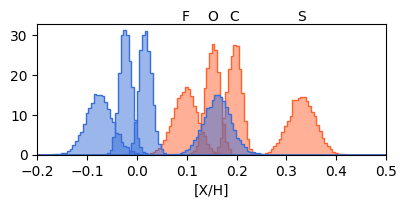

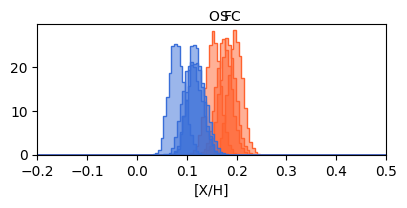

In [28]:
log_g_norm_factor_A = 10**(4.96-log_g_A)
log_g_norm_factor_B = 10**(4.88-log_g_B)

log_g_norm_factor_A_eq = 10**(4.96-log_g_A_eq)
log_g_norm_factor_B_eq = 10**(4.88-log_g_B_eq)

log_g_norm_factor_A_J = 10**(4.96-log_g_A_J)
log_g_norm_factor_B_J = 10**(4.88-log_g_B_J)

bins = 130; hist_range = [-0.2,0.5]
fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(abs_abund_A['C/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('C', xy=(np.median(abs_abund_A['C/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.hist(abs_abund_A['O/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('O', xy=(np.median(abs_abund_A['O/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
# ax.hist(abs_abund_A['N/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('N', xy=(np.median(abs_abund_A['N/H']), 0.9), xycoords=ax.get_xaxis_transform(), ha='center', va='center')
ax.hist(abs_abund_A['S/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('S', xy=(np.median(abs_abund_A['S/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.hist(abs_abund_A['F/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('F', xy=(np.median(abs_abund_A['F/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')

ax.hist(abs_abund_B['C/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B['O/H'], bins=bins, range=hist_range, **hist_kwargs_B)
# ax.hist(abs_abund_B['N/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B['S/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B['F/H'], bins=bins, range=hist_range, **hist_kwargs_B)

ax.set(xlim=hist_range, xlabel='[X/H]')
plt.show()

fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(abs_abund_A_eq['C/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('C', xy=(np.median(abs_abund_A_eq['C/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.hist(abs_abund_A_eq['O/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('O', xy=(np.median(abs_abund_A_eq['O/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
# ax.hist(abs_abund_A_eq['N/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('N', xy=(np.median(abs_abund_A_eq['N/H']), 0.9), xycoords=ax.get_xaxis_transform(), ha='center', va='center')
ax.hist(abs_abund_A_eq['S/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('S', xy=(np.median(abs_abund_A_eq['S/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.hist(abs_abund_A_eq['F/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('F', xy=(np.median(abs_abund_A_eq['F/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')

ax.hist(abs_abund_B_eq['C/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B_eq['O/H'], bins=bins, range=hist_range, **hist_kwargs_B)
# ax.hist(abs_abund_B_eq['N/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B_eq['S/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B_eq['F/H'], bins=bins, range=hist_range, **hist_kwargs_B)

ax.set(xlim=hist_range, xlabel='[X/H]')
plt.show()

In [29]:
def get_FeH_posterior(Res):
    # Load the ParamTable module
    Res.load_components(['ParamTable'])
    
    # Get the indices of the free parameters
    idx_free = Res.ParamTable.get('Fe/H', key='idx_free')
    return Res.posterior[:,idx_free]

FeH_A_eq = get_FeH_posterior(A_eq)
FeH_B_eq = get_FeH_posterior(B_eq)

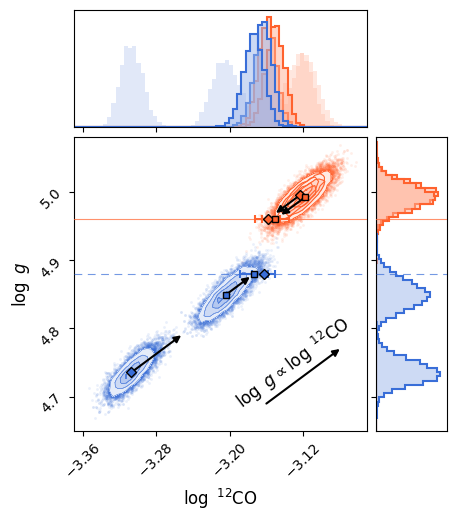

In [30]:
species = '12CO'

ylim = (4.65,5.08)
xlim = -3.21 + np.array([-1,1])*np.diff(ylim)/2
xlim = (-3.37, -3.05)

post_A = np.array([np.log10(abs_abund_A[species]), log_g_A]).T
post_A_eq = np.array([np.log10(abs_abund_A_eq[species]), log_g_A_eq]).T
post_B = np.array([np.log10(abs_abund_B[species]), log_g_B]).T
post_B_eq = np.array([np.log10(abs_abund_B_eq[species]), log_g_B_eq]).T

log_g_A_ref = 4.96
log_g_B_ref = 4.88

corner_kwargs = dict(
    bins=70, 
    range=[xlim, ylim],
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    use_math_text=True, title_fmt='.2f', title_kwargs={'fontsize':10}, labelpad=-0.03, 
    # smooth=True, 
)

corner_kwargs_A = corner_kwargs.copy()
corner_kwargs_A.update({
    'color': color_A,
    'hist_kwargs': {'edgecolor':color_A, 'facecolor':env_colors_A[2], 'fill':True, 'density':True, 'lw':1.5},
    'contourf_kwargs': {'colors':env_colors_A},
    'contour_kwargs': {'linewidths':0.8, 'colors':color_A},
})

corner_kwargs_B = corner_kwargs.copy()
corner_kwargs_B.update({
    'color': color_B,
    'hist_kwargs': {'edgecolor':color_B, 'facecolor':env_colors_B[2], 'fill':True, 'density':True, 'lw':1.5},
    'contourf_kwargs': {'colors':env_colors_B},
    'contour_kwargs': {'linewidths':0.4, 'colors':color_B},
})

fig = plt.figure(figsize=(4.5,5.2))

for post_i in [post_A, post_A_eq]:
    fig = corner.corner(fig=fig, data=post_i, **corner_kwargs_A)
for post_i in [post_B, post_B_eq]:
    fig = corner.corner(fig=fig, data=post_i, **corner_kwargs_B)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

ax[0,0].set(xlim=xlim)
ax[1,0].set(xlim=xlim, ylim=ylim)
ax[0,1].set(xlim=ylim)

# Rotate the axis and apply height/width ratios
for i, patch_i in enumerate(list(ax[1,1].patches)):
    patch_i.set_xy(np.array([patch_i.xy[:,1],patch_i.xy[:,0]]).T)

for i, patch_i in enumerate(list(ax[0,0].patches)):
    patch_i.set_linewidth(0.)
    patch_i.set_alpha(0.3)

ylim = ax[0,0].get_ylim()
ax[0,0].set(ylim=(ylim[0], ylim[1]*1.6))

xlim, ylim = ax[1,0].get_ylim(), ax[1,1].get_ylim()
ax[1,1].set(yticks=ax[1,1].get_xticks(), xticks=ax[1,1].get_yticks())
ax[1,1].set(ylim=xlim, xlim=(ylim[0],ylim[1]*1.2), xlabel=None)

gs = ax[0,0].get_gridspec()
gs.set_height_ratios([1,2.5]); gs.set_width_ratios([2.5,0.6])
gs.update()


def plot_deprojection_arrow(ax, xc, yc, l=0.02, color='k', lw=1.5, symm=False):
    dx = np.sqrt(2)*l; dy = dx
    xy_0 = (xc, yc)
    xy_1 = (xc+dx, yc+dy)
    if symm:
        xy_0 = (xc-dx, yc-dy)

    ax.annotate('', xy=xy_0, xytext=xy_1, arrowprops=dict(arrowstyle='<|-', color=color, lw=lw))
    # ax.arrow(xy_0[0], xy_0[1], xy_1[0]-xy_0[0], xy_1[1]-xy_0[1], ec='w', color=color, width=0.005)

def plot_deprojection(ax, post, log_g_norm_factor, log_g_ref, corner_kwargs, marker='s', ms=5, arrow_kwargs={'l':0.02}):
    
    deprojected = np.log10(10**post[:,0]*log_g_norm_factor)
    plot_deprojection_arrow(ax[1,0], np.median(post[:,0]), np.median(post[:,1]), **arrow_kwargs)

    ax[1,0].plot(
        np.median(post[:,0]), np.median(post[:,1]), marker=marker, ms=ms, mec='k', color=corner_kwargs['color'], zorder=10
        )
    ax[1,0].errorbar(
        np.median(deprojected), log_g_ref, xerr=np.std(post[:,0]), fmt=marker, ms=ms, mec='k',
        color=corner_kwargs['color'], zorder=10, elinewidth=1.5, capsize=3, capthick=1.5,
    )
    
    ax[0,0].hist(
        deprojected, bins=corner_kwargs['bins'], range=corner_kwargs['range'][0], 
        **corner_kwargs['hist_kwargs']
        )

plot_deprojection(ax, post_A, log_g_norm_factor_A, log_g_A_ref, corner_kwargs_A, arrow_kwargs={'l':-0.02}, marker='D')
plot_deprojection(ax, post_A_eq, log_g_norm_factor_A_eq, log_g_A_ref, corner_kwargs_A, arrow_kwargs={'l':-0.02})
plot_deprojection(ax, post_B, log_g_norm_factor_B, log_g_B_ref, corner_kwargs_B, arrow_kwargs={'l':0.04}, marker='D')
plot_deprojection(ax, post_B_eq, log_g_norm_factor_B_eq, log_g_B_ref, corner_kwargs_B)

plot_deprojection_arrow(ax[1,0], -3.12, 4.73, l=0.03, symm=True)
ax[1,0].annotate(r'$\log\ g\propto\log\ \mathrm{^{12}CO}$', xy=(-3.13, 4.75), rotation=37, ha='center', va='center', fontsize=12)


kwargs_A = dict(lw=0.8, c=color_A, zorder=10, alpha=0.7)
kwargs_B = kwargs_A.copy()
kwargs_B['ls'] = (0,(7,5)); kwargs_B['c'] = color_B
for ax_i in ax[1,:]:
    ax_i.plot([0.,1.0], [log_g_A_ref]*2, transform=ax_i.get_yaxis_transform(), **kwargs_A)
    ax_i.plot([0.,1.0], [log_g_B_ref]*2, transform=ax_i.get_yaxis_transform(), **kwargs_B)

ax[1,0].set_xlabel(r'$\log\ \mathrm{^{12}CO}$', fontsize=12)
ax[1,0].set_ylabel(r'$\log\ g$', fontsize=12)

plt.subplots_adjust(left=0.14, bottom=0.15, top=0.96, right=0.97)
plt.savefig('./plots/K_band_logg.pdf')
plt.show()

/var/tmp/regt/ipykernel_1930380/4056419412.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=0)
/var/tmp/regt/ipykernel_1930380/4056419412.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), rotation=0)


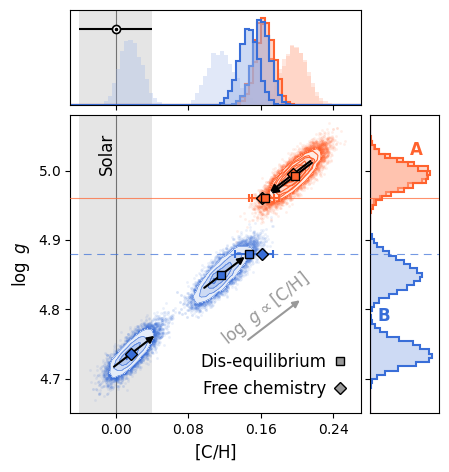

In [31]:
species = 'C/H'

ylim = (4.65,5.08)
# xlim = -3.21 + np.array([-1,1])*np.diff(ylim)/2
# xlim = (-3.37, -3.05)
xlim = (-0.05,0.27)

post_A = np.array([abs_abund_A[species], log_g_A]).T
post_A_eq = np.array([abs_abund_A_eq[species], log_g_A_eq]).T
post_B = np.array([abs_abund_B[species], log_g_B]).T
post_B_eq = np.array([abs_abund_B_eq[species], log_g_B_eq]).T

log_g_A_ref = 4.96
log_g_B_ref = 4.88

corner_kwargs = dict(
    bins=70, 
    range=[xlim, ylim],
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    use_math_text=True, title_fmt='.2f', title_kwargs={'fontsize':10}, labelpad=-0.03, 
    # smooth=True, 
)

corner_kwargs_A = corner_kwargs.copy()
corner_kwargs_A.update({
    'color': color_A,
    'hist_kwargs': {'edgecolor':color_A, 'facecolor':env_colors_A[2], 'fill':True, 'density':True, 'lw':1.5},
    'contourf_kwargs': {'colors':env_colors_A},
    'contour_kwargs': {'linewidths':0.8, 'colors':color_A},
})

corner_kwargs_B = corner_kwargs.copy()
corner_kwargs_B.update({
    'color': color_B,
    'hist_kwargs': {'edgecolor':color_B, 'facecolor':env_colors_B[2], 'fill':True, 'density':True, 'lw':1.5},
    'contourf_kwargs': {'colors':env_colors_B},
    'contour_kwargs': {'linewidths':0.4, 'colors':color_B},
})

fig = plt.figure(figsize=(4.5,4.8))

for post_i in [post_A, post_A_eq]:
    fig = corner.corner(fig=fig, data=post_i, **corner_kwargs_A)
for post_i in [post_B, post_B_eq]:
    fig = corner.corner(fig=fig, data=post_i, **corner_kwargs_B)

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), rotation=0)
ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), rotation=0)

ax[0,0].set(xlim=xlim)
ax[1,0].set(xlim=xlim, ylim=ylim)
ax[0,1].set(xlim=ylim)

# Rotate the axis and apply height/width ratios
for i, patch_i in enumerate(list(ax[1,1].patches)):
    patch_i.set_xy(np.array([patch_i.xy[:,1],patch_i.xy[:,0]]).T)

for i, patch_i in enumerate(list(ax[0,0].patches)):
    patch_i.set_linewidth(0.)
    patch_i.set_alpha(0.3)

ylim = ax[0,0].get_ylim()
ax[0,0].set(ylim=(ylim[0], ylim[1]*1.6))

xlim, ylim = ax[1,0].get_ylim(), ax[1,1].get_ylim()
ax[1,1].set(yticks=ax[1,1].get_xticks(), xticks=ax[1,1].get_yticks())
ax[1,1].set(ylim=xlim, xlim=(ylim[0],ylim[1]*1.2), xlabel=None)

gs = ax[0,0].get_gridspec()
gs.set_height_ratios([0.8,2.5]); gs.set_width_ratios([2.5,0.6])
gs.update()


def plot_deprojection_arrow(ax, xc, yc, l=0.02, color='k', lw=1.5, symm=False):
    dx = np.sqrt(2)*l; dy = dx
    xy_0 = (xc, yc)
    xy_1 = (xc+dx, yc+dy)
    if symm:
        xy_0 = (xc-dx*0.75, yc-dy*0.75)

    ax.annotate('', xy=xy_0, xytext=xy_1, arrowprops=dict(arrowstyle='<|-', color=color, lw=lw))
    # ax.arrow(xy_0[0], xy_0[1], xy_1[0]-xy_0[0], xy_1[1]-xy_0[1], ec='w', color=color, width=0.005)

def plot_deprojection(ax, post, log_g_norm_factor, log_g_ref, corner_kwargs, marker='s', ms=6, arrow_kwargs={'l':0.02}, label=None):
    
    deprojected = np.log10(10**post[:,0]*log_g_norm_factor)
    plot_deprojection_arrow(ax[1,0], np.median(post[:,0]), np.median(post[:,1]), **arrow_kwargs)

    ax[1,0].plot(
        np.median(post[:,0]), np.median(post[:,1]), marker=marker, ms=ms, mec='k', 
        color=corner_kwargs['color'], zorder=10, label=label
        )
    ax[1,0].errorbar(
        np.median(deprojected), log_g_ref, xerr=np.std(post[:,0]), fmt=marker, ms=ms, mec='k',
        color=corner_kwargs['color'], zorder=10, elinewidth=1.5, capsize=3, capthick=1.5,
    )
    
    ax[0,0].hist(
        deprojected, bins=corner_kwargs['bins'], range=corner_kwargs['range'][0], 
        **corner_kwargs['hist_kwargs']
        )

plot_deprojection(ax, post_A, log_g_norm_factor_A, log_g_A_ref, corner_kwargs_A, arrow_kwargs={'l':-0.02, 'symm':True}, marker='D')
plot_deprojection(ax, post_A_eq, log_g_norm_factor_A_eq, log_g_A_ref, corner_kwargs_A, arrow_kwargs={'l':-0.02, 'symm':True})
plot_deprojection(ax, post_B, log_g_norm_factor_B, log_g_B_ref, corner_kwargs_B, arrow_kwargs={'l':0.02, 'symm':True}, marker='D')
plot_deprojection(ax, post_B_eq, log_g_norm_factor_B_eq, log_g_B_ref, corner_kwargs_B, arrow_kwargs={'l':0.02, 'symm':True})

plot_deprojection_arrow(ax[1,0], 0.17, 4.78, l=0.025, symm=True, color='0.6')
ax[1,0].annotate(r'$\log\ g\propto\mathrm{['+species+']}$', xy=(0.165, 4.8), rotation=38, ha='center', va='center', fontsize=12, color='0.6')

ax[1,0].plot(np.nan, np.nan, marker='s', ms=6, mec='k', color='0.6', label='Dis-equilibrium')
ax[1,0].plot(np.nan, np.nan, marker='D', ms=6, mec='k', color='0.6', label='Free chemistry')
ax[1,0].legend(
    loc='lower right', bbox_to_anchor=(0.95,0.03), handlelength=0., frameon=False, markerfirst=False, borderaxespad=0.0, prop={'size':12},
)

kwargs = dict(lw=1.5, ms=5, capsize=0, c='k')
ann_kwargs = dict(ha='center', va='top', fontsize=12)
y = 0.8; ydiff = 0.07
[ax_i.axvline(0., color='k', lw=0.8, ls='-', alpha=0.5, zorder=-20) for ax_i in ax[:,0]]
[ax_i.axvspan(-0.04, 0.04, color='k', alpha=0.1, lw=0., zorder=-20) for ax_i in ax[:,0]]
ax[0,0].errorbar(0., y, xerr=0.04, transform=ax[0,0].get_xaxis_transform(), fmt='', **kwargs)
add_odot(ax[0,0], 0., y, color='k', ms=6, mec='w')
ax[1,0].annotate('Solar', xy=(0-0.01,0.87), xycoords=ax[1,0].get_xaxis_transform(), ha='center', va='center', fontsize=12, rotation=90)

kwargs_A = dict(lw=0.8, c=color_A, zorder=10, alpha=0.7)
kwargs_B = kwargs_A.copy()
kwargs_B['ls'] = (0,(7,5)); kwargs_B['c'] = color_B
for ax_i in ax[1,:]:
    ax_i.plot([0.,1.0], [log_g_A_ref]*2, transform=ax_i.get_yaxis_transform(), **kwargs_A)
    ax_i.plot([0.,1.0], [log_g_B_ref]*2, transform=ax_i.get_yaxis_transform(), **kwargs_B)

# ax[1,0].set_xlabel(r'$\log\ \mathrm{^{12}CO}$', fontsize=12)
ax[1,0].set_xlabel(r'$\mathrm{['+species+']}$', fontsize=12)
ax[1,0].set_ylabel(r'$\log\ g$', fontsize=12)

ax[1,1].annotate('A', xy=(17,5.03), fontsize=12, color=color_A, fontweight='bold', ha='center', va='center')
ax[1,1].annotate('B', xy=(5,4.79), fontsize=12, color=color_B, fontweight='bold', ha='center', va='center')

plt.subplots_adjust(left=0.15, bottom=0.12, top=0.96, right=0.97)
plt.savefig('./plots/K_band_met_logg.pdf')
plt.show()

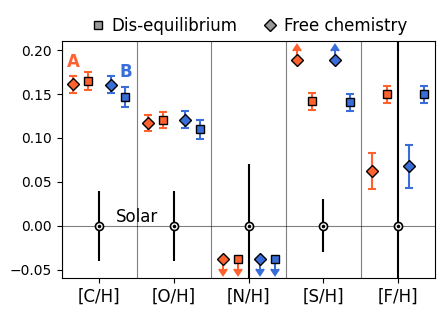

In [15]:
def plot_metallicity(ax, x, abs_abund, log_g_norm_factor, species, fmt='s', ms=6, mec='k', color=color_A, zorder=10, elinewidth=1.5, capsize=3, capthick=1.5, **kwargs):
    
    for x_i, species_i in zip(x, species):
        if species_i not in abs_abund:
            continue
        post = np.log10(10**abs_abund[species_i]*log_g_norm_factor)
        y = np.median(post)
        yerr = np.std(post)
        if y > ax.get_ylim()[1] or y < ax.get_ylim()[0]:
            yerr = 0.04
            if y < ax.get_ylim()[0]:
                y = 0.08; uplims = True; lolims = False
            else:
                y = 0.92; lolims = True; uplims = False
            ax.errorbar(
                x_i, y, yerr=yerr, transform=ax.get_xaxis_transform(), 
                lolims=lolims, uplims=uplims,
                fmt=fmt, ms=ms, mec=mec, color=color, zorder=zorder, elinewidth=elinewidth,
                capsize=capsize, capthick=capthick, **kwargs
            )
            continue

        ax.errorbar(
            x_i, y, yerr=np.std(post), fmt=fmt, ms=ms, mec=mec,
            color=color, zorder=zorder, elinewidth=elinewidth, capsize=capsize, 
            capthick=capthick, **kwargs
        )

x = np.arange(0.5,5.0,1.0)
species = ['C/H', 'O/H', 'N/H', 'S/H', 'F/H']
yerr = [0.04, 0.04, 0.07, 0.03, 0.25]

fig, ax = plt.subplots(figsize=(4.5,3.0))
# ax.set(xlim=(0.,5.), ylim=(-0.06,0.21), xticks=x)
ax.set(xlim=(0.,5.), ylim=(-0.06,0.21), xticks=x)

plot_metallicity(ax, x-0.25-0.1, abs_abund_A, log_g_norm_factor_A, species=species, color=color_A, fmt='D')
plot_metallicity(ax, x+0.25-0.1, abs_abund_B, log_g_norm_factor_B, species=species, color=color_B, fmt='D')

abs_abund_A_eq['Fe/H'] = FeH_A_eq
abs_abund_B_eq['Fe/H'] = FeH_B_eq
plot_metallicity(ax, x-0.25+0.1, abs_abund_A_eq, log_g_norm_factor_A_eq, species=species, color=color_A)
plot_metallicity(ax, x+0.25+0.1, abs_abund_B_eq, log_g_norm_factor_B_eq, species=species, color=color_B)

ax.plot(np.nan, np.nan, marker='s', ms=6, mec='k', color='0.6', label='Dis-equilibrium')
ax.plot(np.nan, np.nan, marker='D', ms=6, mec='k', color='0.6', label='Free chemistry')
ax.legend(
    loc='lower center', bbox_to_anchor=(0.51,1.0), handlelength=0., frameon=False, borderaxespad=0., prop={'size':12}, ncols=2, 
)

ax.annotate('A', xy=(x[0]-0.25-0.1,0.187), fontsize=12, color=color_A, fontweight='bold', ha='center', va='center')
ax.annotate('B', xy=(x[0]+0.25+0.1,0.175), fontsize=12, color=color_B, fontweight='bold', ha='center', va='center')

ax.annotate('Solar', xy=(1,0.), ha='center', va='bottom', fontsize=12, color='k')
ax.axhline(0., color='k', lw=0.8, ls='-', alpha=0.5, zorder=-20)
for x_i, species_i, yerr_i in zip(x, species, yerr):
    if species_i not in abs_abund_A:
        continue
    ax.errorbar(x_i, 0., yerr=yerr_i, lw=1.5, ms=5, capsize=0, c='k')
    add_odot(ax, x_i, 0., color='k', ms=6, mec='w', transform=ax.transData)

    ax.axvline(x_i-0.5, color='k', lw=0.8, alpha=0.5, zorder=-20)

ax.set_xticklabels([f'[{species_i}]' for species_i in species], fontsize=12)
# ax.set_ylabel(r'$\mathrm{[X/H]}$', fontsize=12)
plt.subplots_adjust(left=0.14, bottom=0.11, top=0.90, right=0.97)
plt.savefig('./plots/K_band_abs_abund.pdf')
plt.show()

In [23]:
result_utils.latex_format(np.log10(10**abs_abund_A['S/H']*log_g_norm_factor_A), np.log10(10**abs_abund_B['S/H']*log_g_norm_factor_B), decimals=2)

$0.30^{+0.02}_{-0.02}$ & $0.31^{+0.02}_{-0.03}$ \\


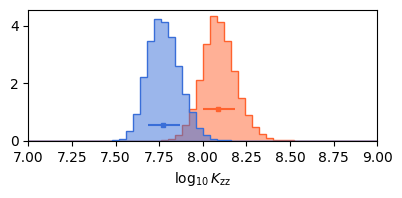

In [320]:
log_Kzz_A_eq = A_eq.posterior[:,A_eq.ParamTable.get('log_Kzz_chem', key='idx_free')]
log_Kzz_B_eq = B_eq.posterior[:,B_eq.ParamTable.get('log_Kzz_chem', key='idx_free')]

bins = 50; hist_range = [7.0,9.0]
fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(log_Kzz_A_eq, label='A', bins=bins, range=hist_range, **hist_kwargs_A_eq)
ax.hist(log_Kzz_B_eq, label='B', bins=bins, range=hist_range, **hist_kwargs_B_eq)
# ax.hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
plot_errorbar(ax, log_Kzz_A_eq, y=0.24, q=result_utils.q[[2,4]], color=color_A)
plot_errorbar(ax, log_Kzz_B_eq, y=0.12, q=result_utils.q[[2,4]], color=color_B)
ax.set(xlim=hist_range, xlabel=r'$\log_{10} K_\mathrm{zz}$')
plt.show()

In [ ]:
from tqdm import tqdm
import copy

A_eq.load_components(['PT'])
B_eq.load_components(['PT'])

# Turn off the quenching
# A_eq.Chem['K2166_1'].quench_VMRs = lambda *args, **kwargs: None
# B_eq.Chem['K2166_1'].quench_VMRs = lambda *args, **kwargs: None

Chem_A_eq_wo_quenching = copy.deepcopy(A_eq.Chem['K2166_1'])
Chem_B_eq_wo_quenching = copy.deepcopy(B_eq.Chem['K2166_1'])

idx_A = list(np.random.randint(0, A_eq.posterior.shape[0], size=1000))
idx_B = list(np.random.randint(0, B_eq.posterior.shape[0], size=1000))

Chem_A_eq_wo_quenching.quench_settings_posterior = {key: [] for key in Chem_A_eq_wo_quenching.quench_settings.keys()}
Chem_B_eq_wo_quenching.quench_settings_posterior = {key: [] for key in Chem_B_eq_wo_quenching.quench_settings.keys()}
Chem_A_eq_wo_quenching.VMRs_posterior = {species: [] for species in Chem_A_eq_wo_quenching.VMRs.keys()}
Chem_B_eq_wo_quenching.VMRs_posterior = {species: [] for species in Chem_B_eq_wo_quenching.VMRs.keys()}

for i, sample in enumerate(tqdm(A_eq.posterior[idx_A], desc='A_eq')):
    # Update the parameters
    A_eq.ParamTable.set_apply_prior(False)
    A_eq.ParamTable(cube=sample)
    A_eq.ParamTable.set_apply_prior(True)

    # Calculate the VMRs
    Chem_A_eq_wo_quenching(A_eq.ParamTable, A_eq.PT['K2166_1'].temperature_posterior[idx_A][i])
    for species in Chem_A_eq_wo_quenching.VMRs_posterior.keys():
        Chem_A_eq_wo_quenching.VMRs_posterior[species].append(Chem_A_eq_wo_quenching.VMRs[species])

    for key, value in Chem_A_eq_wo_quenching.quench_settings.items():
        Chem_A_eq_wo_quenching.quench_settings_posterior[key].append(value[-1])
        
for i, sample in enumerate(tqdm(B_eq.posterior[idx_B], desc='B_eq')):
    # Update the parameters
    B_eq.ParamTable.set_apply_prior(False)
    B_eq.ParamTable(cube=sample)
    B_eq.ParamTable.set_apply_prior(True)

    # Calculate the VMRs
    Chem_B_eq_wo_quenching(B_eq.ParamTable, B_eq.PT['K2166_1'].temperature_posterior[idx_B][i])
    for species in Chem_B_eq_wo_quenching.VMRs_posterior.keys():
        Chem_B_eq_wo_quenching.VMRs_posterior[species].append(Chem_B_eq_wo_quenching.VMRs[species])

    for key, value in Chem_B_eq_wo_quenching.quench_settings.items():
        Chem_B_eq_wo_quenching.quench_settings_posterior[key].append(value[-1])

# Convert the lists to numpy arrays
for key in Chem_A_eq_wo_quenching.quench_settings_posterior.keys():
    Chem_A_eq_wo_quenching.quench_settings_posterior[key] = np.array(Chem_A_eq_wo_quenching.quench_settings_posterior[key])
    Chem_B_eq_wo_quenching.quench_settings_posterior[key] = np.array(Chem_B_eq_wo_quenching.quench_settings_posterior[key])

/var/tmp/regt/ipykernel_887389/2827669456.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(


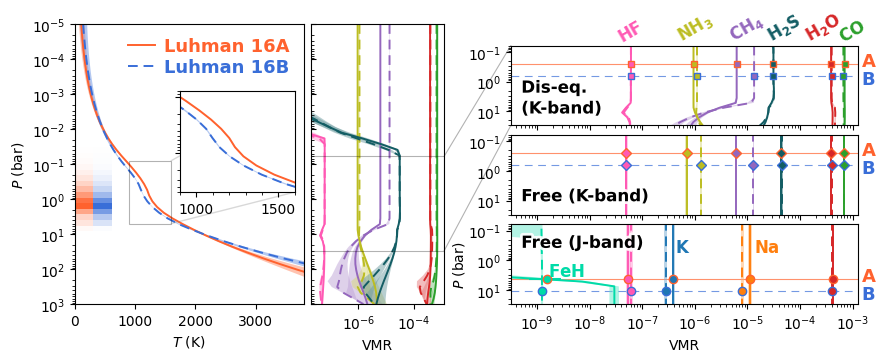

In [321]:
log_g_norm_factor_A = 10**(4.96-log_g_A)
log_g_norm_factor_B = 10**(4.88-log_g_B)
log_g_norm_factor_A_eq = 10**(4.96-log_g_A_eq)
log_g_norm_factor_B_eq = 10**(4.88-log_g_B_eq)
log_g_norm_factor_A_J = 10**(4.96-log_g_A_J)
log_g_norm_factor_B_J = 10**(4.88-log_g_B_J)

# log_g_norm_factor_A = np.ones_like(log_g_A); log_g_norm_factor_B = np.ones_like(log_g_B)
# log_g_norm_factor_A_eq = np.ones_like(log_g_A_eq); log_g_norm_factor_B_eq = np.ones_like(log_g_B_eq)
# log_g_norm_factor_A_J = np.ones_like(log_g_A_J); log_g_norm_factor_B_J = np.ones_like(log_g_B_J)

contr_A_eq = A_eq.get_contribution_function()
contr_B_eq = B_eq.get_contribution_function()

A.load_components(['PT']); B.load_components(['PT'])
A_eq.load_components(['PT']); B_eq.load_components(['PT'])
A_J.load_components(['PT']); B_J.load_components(['PT'])

y_A = 10**(np.log10(0.4)-0.2)
y_B = 10**(np.log10(0.4)+0.2)

# xlim_VMR = (10**(-7.7), 10**(-2.8))
xlim_VMR = (10**(-9.5), 10**(-2.9))
ylim_VMR = (30,0.06)

fig = plt.figure(figsize=(9,3.5))
gs = fig.add_gridspec(
    # ncols=3, nrows=5, hspace=0.15, wspace=0.05, width_ratios=[0.3,0.35,0.35], height_ratios=[0.2,1,1,1,0.2], 
    ncols=5, nrows=4, hspace=0.15, wspace=0.05, width_ratios=[0.05,0.25,0.18,0.07,0.47], height_ratios=[0.15,1,1,1], 
    )

ax_contr = fig.add_subplot(gs[:,0])
ax_PT = fig.add_subplot(gs[:,:2])
ax_VMR = fig.add_subplot(gs[:,2])

ax_eq = fig.add_subplot(gs[1,-1])
ax_fc = fig.add_subplot(gs[2,-1])
ax_J = fig.add_subplot(gs[3,-1])

# --- PT profiles --------------------------------------
ax_contr.imshow(
    contr_A_eq['K2166_1'].reshape(-1,1), cmap=cmap_A, aspect='auto', interpolation='none', 
    extent=[0,0.5,0,1], transform=ax_contr.transAxes, 
)
ax_contr.imshow(
    contr_B_eq['K2166_1'].reshape(-1,1), cmap=cmap_B, aspect='auto', interpolation='none', 
    extent=[0.5,1,0,1], transform=ax_contr.transAxes, 
)
ax_contr.set_axis_off()
ax_contr.set(yticks=[], xticks=[])

# --- PT profiles --------------------------------------
ax_ins = ax_PT.inset_axes(
    bounds=(0.46,0.40,0.50,0.36), transform=ax_PT.transAxes, #xlim=(1000,1500), ylim=(1e1,1e-1), 
)
ax_ins.set_xticks([900,1100,1200,1300,1400,1500,1600], minor=True)
ax_ins.set_xticks([1000,1500])
ax_ins.set(yscale='log', xlim=(900,1600), ylim=(5e0,8e-2), yticklabels=[])
ax_PT.indicate_inset_zoom(ax_ins, ec='k', lw=0.8, alpha=0.3)
# ax_ins = None

for ax_i in [ax_PT, ax_ins]:
    if ax_i is None:
        continue
    temperature_q = result_utils.profile_quantiles(A_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, A_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_A, lw=1.4), 
        **dict(fc=env_colors_A[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
        )
    temperature_q = result_utils.profile_quantiles(B_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, B_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
        **dict(fc=env_colors_B[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
        )
    
    # if ax_i is ax_PT:
    #     continue
    
    # temperature_q = result_utils.profile_quantiles(A.PT['K2166_1'].temperature_posterior)
    # plot_envelopes(
    #     ax_i, A.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_A, lw=1.4, ls=':'), 
    #     **dict(fc=env_colors_A[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
    #     )
    # temperature_q = result_utils.profile_quantiles(B.PT['K2166_1'].temperature_posterior)
    # plot_envelopes(
    #     ax_i, B.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_B, lw=1.4, ls=':'), 
    #     **dict(fc=env_colors_B[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
    #     )
    
handle_A, = ax_PT.plot(np.nan, np.nan, color=color_A, lw=1.4, label='Luhman 16A')
handle_B, = ax_PT.plot(np.nan, np.nan, color=color_B, lw=1.4, ls=(0,(5,3)), label='Luhman 16B')
ax_PT.legend(
    loc='upper right', bbox_to_anchor=(0.97,0.98), frameon=False, 
    handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderaxespad=0.0, 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)
ax_PT.set(
    xlim=(0,3800), xlabel=r'$T$ (K)', #xticks=[0,1000,2000,3000],
    yscale='log', ylim=(1e3, 1e-5), facecolor='none', ylabel=r'$P$ (bar)',
)

# --- VMR profiles -------------------------------------
species_info = {
    '12CO': ('C2', 'CO', (+0.15,0)), 
    'H2O': ('C3', 'H_2O', (-0.15,0)),
    'CH4': ('C4', 'CH_4', (0,0)),
    'NH3': ('C8', 'NH_3', (0,0)),
    'H2S': ('#135D64', 'H_2S', (+0.2,0)),
    'HF': ('#FF59B4', 'HF', (0,0)),
}
for species, (c, l, xy) in species_info.items():
    l = r'$\mathrm{\bf '+f'{l}'+'}$'
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    plot_VMR_envelope(
        ax_VMR, A_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_A_eq[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_VMR_envelope(
        ax_VMR, B_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_B_eq[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )

    x = np.mean([np.median(abs_abund_A_eq[species]), np.median(abs_abund_B_eq[species])])
    x = 10**(np.log10(x)+xy[0])
    y = 1 + xy[1]
    ax_eq.annotate(
        l, xy=(x,y), xycoords=ax_eq.get_xaxis_transform(), ha='center', va='bottom', fontsize=12, c=c, rotation=30, 
        )
    
ax_VMR.tick_params(axis='y', which='both', direction='in')
ax_VMR.set(
    xscale='log', xlim=(10**(-7.7),xlim_VMR[1]), xlabel='VMR', yscale='log', ylim=(1e3, 1e-5), yticklabels=[], 
    )

# --- VMR at photosphere -------------------------------
for i, ax_i in enumerate([ax_eq, ax_fc, ax_J]):
    ax_i.set(yscale='log', ylim=ylim_VMR)
    ax_i.set(xscale='log', xlim=xlim_VMR, xlabel='VMR')
    if i != 2:
        ax_i.set_xticklabels([])
        # ax_i.set_yticklabels([])
        ax_i.set_xlabel('')
    else:
        ax_i.set_ylabel(r'$P$ (bar)', labelpad=1)

    # ax_i.set_yticks([1e1,1e0,1e-1]); ax_i.set_yticklabels([r'$10$', r'$1$', r'$0.1$'])
    ax_i.set_yticks([1e1,1e0,1e-1]); ax_i.set_yticklabels([r'$10^1$', r'$10^0$', r'$10^{-1}$'])

ann_kwargs = dict(
    xycoords='axes fraction', fontsize=12, c='k', fontweight='bold',
    path_effects=[pe.withStroke(linewidth=4, foreground='w', alpha=0.9)],
)
ax_eq.annotate('Dis-eq.\n(K-band)', ha='left', va='bottom', xy=(0.03,0.1), **ann_kwargs)
ax_fc.annotate('Free (K-band)', ha='left', va='bottom', xy=(0.03,0.12), **ann_kwargs)
ax_J.annotate('Free (J-band)', ha='left', va='top', xy=(0.03,0.88), **ann_kwargs)

from matplotlib.patches import ConnectionPatch
kwargs = dict(coordsA=ax_VMR.get_yaxis_transform(), coordsB=ax_eq.get_yaxis_transform(), color='k', lw=0.8, alpha=0.3)
con = ConnectionPatch(xyA=(1, ylim_VMR[1]), xyB=(0, ylim_VMR[1]), **kwargs); ax_VMR.add_artist(con)
con = ConnectionPatch(xyA=(1, ylim_VMR[0]), xyB=(0, ylim_VMR[0]), **kwargs); ax_VMR.add_artist(con)
# ax_VMR.plot([1, 1], [1e-1, 15], transform=ax_VMR.get_yaxis_transform(), lw=1.6, c='k', clip_on=False)
ax_VMR.plot([0,1,1,0], [ylim_VMR[1],ylim_VMR[1],ylim_VMR[0],ylim_VMR[0]], transform=ax_VMR.get_yaxis_transform(), color='k', lw=0.8, alpha=0.3)

for species, (c, l, xy) in species_info.items():
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    plot_VMR_envelope(
        ax_eq, A_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_A_eq[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5), 
        )
    plot_errorbar(
        ax_eq, abs_abund_A_eq[species]*log_g_norm_factor_A_eq, y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_eq.transData, ms=5, mec=color_A
        )

    plot_VMR_envelope(
        ax_fc, A.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_A[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_fc, abs_abund_A[species]*log_g_norm_factor_A, y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_fc.transData, marker='D', ms=5, mec=color_A
        )
    
    plot_VMR_envelope(
        ax_eq, B_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_B_eq[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_eq, abs_abund_B_eq[species]*log_g_norm_factor_B_eq, y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_eq.transData, ms=5, mec=color_B
        )

    plot_VMR_envelope(
        ax_fc, B.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor_B[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_fc, abs_abund_B[species]*log_g_norm_factor_B, y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_fc.transData, marker='D', ms=5, mec=color_B
        )
    
species_info = {
    'H2O': ('C3', 'H_2O', (-0.2,0)),
    'HF': ('#FF59B4', 'HF', (0,-0.44)),
    'Na': ('C1', 'Na', (0,0)), 
    'K': ('C0', 'K', (0,0)),
    'FeH': ('#00DBA8', 'FeH', (0,0)),
}
for species, (c, l, xy) in species_info.items():
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    log_g_norm_factor = 10**(4.96-log_g_A_J)
    plot_VMR_envelope(
        ax_J, A_J.Chem['J1226_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_J, abs_abund_A_J[species]*log_g_norm_factor, y=10**(np.log10(7.)-0.2), q=result_utils.q[[2,4]], color=c, transform=ax_J.transData, marker='o', ms=6, mec=color_A
        )
        
    log_g_norm_factor = 10**(4.88-log_g_B_J)
    plot_VMR_envelope(
        ax_J, B_J.Chem['J1226_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_J, abs_abund_B_J[species]*log_g_norm_factor, y=10**(np.log10(7.)+0.2), q=result_utils.q[[2,4]], color=c, transform=ax_J.transData, marker='o', ms=6, mec=color_B
        )

ax_J.annotate(
    r'$\mathrm{\bf FeH}$', xy=(10**(-8.45),0.3), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['FeH'][0], rotation=0, 
    )
ax_J.annotate(
    r'$\mathrm{\bf K}$', xy=(10**(-6.23),0.6), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['K'][0], rotation=0, 
    )
ax_J.annotate(
    r'$\mathrm{\bf Na}$', xy=(10**(-4.62),0.6), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['Na'][0], rotation=0, 
    )

for ax_i, y_cen in zip([ax_eq, ax_fc, ax_J], [0.4,0.4,7.0]):
    ax_i.annotate(
        r'$\mathrm{\bf A}$', xy=(1.01, 10**(np.log10(y_cen)-0.3)), xycoords=ax_i.get_yaxis_transform(), 
        ha='left', va='center', fontsize=13, c=color_A,
        )
    ax_i.annotate(
        r'$\mathrm{\bf B}$', xy=(1.01, 10**(np.log10(y_cen)+0.3)), xycoords=ax_i.get_yaxis_transform(), 
        ha='left', va='center', fontsize=13, c=color_B,
        )
    
    kwargs = dict(lw=0.8, c=color_A, zorder=-1, alpha=0.7)
    ax_i.plot([0.,1.0], [10**(np.log10(y_cen)-0.2)]*2, transform=ax_i.get_yaxis_transform(), **kwargs)
    kwargs['ls'] = (0,(7,5)); kwargs['c'] = color_B
    ax_i.plot([0.,1.0], [10**(np.log10(y_cen)+0.2)]*2, transform=ax_i.get_yaxis_transform(), **kwargs)

plt.subplots_adjust(left=0.09, bottom=0.15, top=0.95, right=0.96)
plt.savefig('./plots/K_band_VMR_profiles.pdf')
plt.show()

## log(g) - metallicity degeneracy

In [ ]:
def get_log_g_posterior(Res):
    # Load the ParamTable module
    Res.load_components(['ParamTable'])
    
    # Get the indices of the free parameters
    idx_free = Res.ParamTable.get('log_g', key='idx_free')
    return Res.posterior[:,idx_free]

log_g_A = get_log_g_posterior(A)
log_g_B = get_log_g_posterior(B)
log_g_A_eq = get_log_g_posterior(A_eq)
log_g_B_eq = get_log_g_posterior(B_eq)

In [ ]:
corner_kwargs = dict(
    bins=15, 
    #range=posterior_ranges, 
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    #labels=labels, 
    #show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    #labelpad=0.03, 
    labelpad=-0.03, 
    
    #smooth=True, 
)
fig = plt.figure(figsize=(4,4))

corner_kwargs['color'] = color_A
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_A, 'facecolor':env_colors_A[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_A}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_A}
fig = corner.corner(
    fig=fig, data=np.array([log_g_A, abs_abund_A['(C+O)/H']]).T, **corner_kwargs,
    # range=[(4.65,4.95),(-0.05,0.15),(-0.05,0.15),(-0.05,0.15)],
    )
# corner_kwargs['hist_kwargs']['fill'] = False
# fig = corner.corner(
#     fig=fig, data=np.array([log_g_A_eq, abs_abund_A_eq['(C+O)/H']]).T, **corner_kwargs,
#     # range=[(4.65,4.95),(-0.05,0.15),(-0.05,0.15),(-0.05,0.15)],
#     )

corner_kwargs['color'] = color_B
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_B, 'facecolor':env_colors_B[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_B}
fig = corner.corner(
    fig=fig, data=np.array([log_g_B, abs_abund_B['(C+O)/H']]).T, **corner_kwargs,
    #range=[(4.65,4.95),(-0.05,0.12),(-0.05,0.12),(-0.05,0.12)],
    )

# corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B*np.array([1,1,1,0.])}
# fig = corner.corner(
#     fig=fig, data=np.array([log_g_B_eq, abs_abund_B_eq['(C+O)/H']]).T, **corner_kwargs,
#     )
plt.show()